## Imports

In [2]:
import math
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

## Helper Functions

## Bussiness Problem

# Data Colection

In [3]:
# Colecting the data
train_df = pd.read_csv('../data/raw/train.csv', low_memory=False)
test_df = pd.read_csv('../data/raw/test.csv', low_memory=False)
store_df = pd.read_csv('../data/raw/store.csv', low_memory=False)

# Merging Train data and Store data
df_raw = train_df.merge(store_df, on='Store', how='left')

In [4]:
# training data
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Rename the columns

In [7]:
# List old cols names
cols_old = df_raw.columns.to_list()

# Lambda function 
snakecase = lambda x : inflection.underscore(x)

# List of new cols name
cols_new = list(map(snakecase, cols_old))

# Rename
df_raw.columns = cols_new

## Data Dimension

In [8]:
print(f'Number of rows {df_raw.shape[0]}')
print(f'Number of rows {df_raw.shape[1]}')

Number of rows 1017209
Number of rows 18


# Data Cleaning

In [9]:
# Change columns date dtype to datetime
df_raw['date'] = pd.to_datetime(df_raw['date'])

In [10]:
# General Info
pd.DataFrame({'missing': df_raw.isna().mean(),
              'uniquesValues': df_raw.nunique(),
              'types': df_raw.dtypes},
              )

,missing,uniquesValues,types
store,0.000000,1115,int64
day_of_week,0.000000,7,int64
date,0.000000,942,datetime64[ns]
sales,0.000000,21734,int64
customers,0.000000,4086,int64
open,0.000000,2,int64
promo,0.000000,2,int64
state_holiday,0.000000,4,object
school_holiday,0.000000,2,int64
store_type,0.000000,4,object


## Missing Data - Fillout

In [11]:
# Listing the columns with missing values
missing_df = pd.DataFrame({'missing': df_raw.isna().mean()}).sort_values(by='missing',ascending=False)
missing_df[missing_df['missing']>0].index.to_list()

['promo_interval',
 'promo2_since_year',
 'promo2_since_week',
 'competition_open_since_year',
 'competition_open_since_month',
 'competition_distance']

In [12]:
%%time
# competition_distance - Probably the NAs values are store that dont have a near competition or its to far lets fill them with a high number
df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else x )

# competition_open_since_month - Lets fill with the month of column date in this way we will be able to calculate(Feature Engineering) time related variables from it.
df_raw['competition_open_since_month'] = df_raw.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df_raw['competition_open_since_year'] = df_raw.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

#  promo2_since_week
df_raw['promo2_since_week'] = df_raw.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df_raw['promo2_since_year'] = df_raw.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1:'Jan', 2:'Fev',3:'Mar',4:'Abr',5:'Mai',6:'Jun',7:'Jul',8:'Ago',9:'Set',10:'Out',11:'Nov',12:'Dez',}

df_raw['promo_interval'].fillna(0, inplace=True)
df_raw['month_map'] = df_raw['date'].dt.month.map(month_map)

df_raw['is_promo'] = df_raw[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

CPU times: user 55.8 s, sys: 825 ms, total: 56.6 s
Wall time: 56.7 s


## Change Dtypes

In [13]:
# checking the dtypes
df_raw.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
# competition_open_since variabels
df_raw['competition_open_since_month'] = df_raw['competition_open_since_month'].astype(int)
df_raw['competition_open_since_year'] = df_raw['competition_open_since_year'].astype(int)

# promo2_since variables
df_raw['promo2_since_week'] = df_raw['promo2_since_week'].astype(int)
df_raw['promo2_since_year'] = df_raw['promo2_since_year'].astype(int)

In [15]:
df_raw.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Data Description

In [16]:
# Numerical variables
num_att = df_raw.select_dtypes(include = ['int', 'float'])

# Categorical variables
cat_att = df_raw.select_dtypes(exclude = ['int', 'float', 'datetime64[ns]'])

### Numerical Attributes

In [17]:
# Central Tendency - mean, median

# Dispertion - std, min, max, range, skew, kurtosis
pd.DataFrame({'min': num_att.min(),
              'max': num_att.max(),
              'range':num_att.max() - num_att.min(), 
              'mean':num_att.mean(),
              'median':num_att.median(),
              'std': num_att.std(),
              'skew': num_att.skew(),
              'kurtosis': num_att.kurt()}).T

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,200000.000000,12.000000,2015.000000,1.000000,52.000000,2015.000000,1.000000
range,1114.000000,6.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,199980.000000,11.000000,115.000000,1.000000,51.000000,6.000000,1.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647,5935.442677,6.786849,2010.324840,0.500564,23.619033,2012.793297,0.083656
median,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000,2330.000000,7.000000,2012.000000,1.000000,22.000000,2013.000000,0.000000
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056,12547.652996,3.311087,5.515593,0.500000,14.310064,1.662658,0.276872
skew,-0.000955,0.001593,0.641460,1.598650,-1.758045,0.487838,1.677842,10.242344,-0.042076,-7.235657,-0.002255,0.178723,-0.784436,3.007488
kurtosis,-1.200524,-1.246873,1.778375,7.091773,1.090723,-1.762018,0.815154,147.789712,-1.232607,124.071304,-1.999999,-1.184046,-0.210075,7.044998


/home/brunods/Documents/portfolio/health_insurence_cross_sell_project/pa004venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_open_since_year', ylabel='Density'>

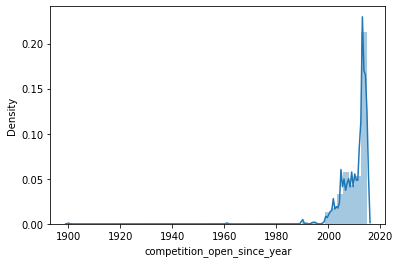

In [18]:
# checking distribution
sns.distplot(df_raw['competition_open_since_year'])

### Categorical Attributes

In [19]:
# Checking levels
cat_att.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

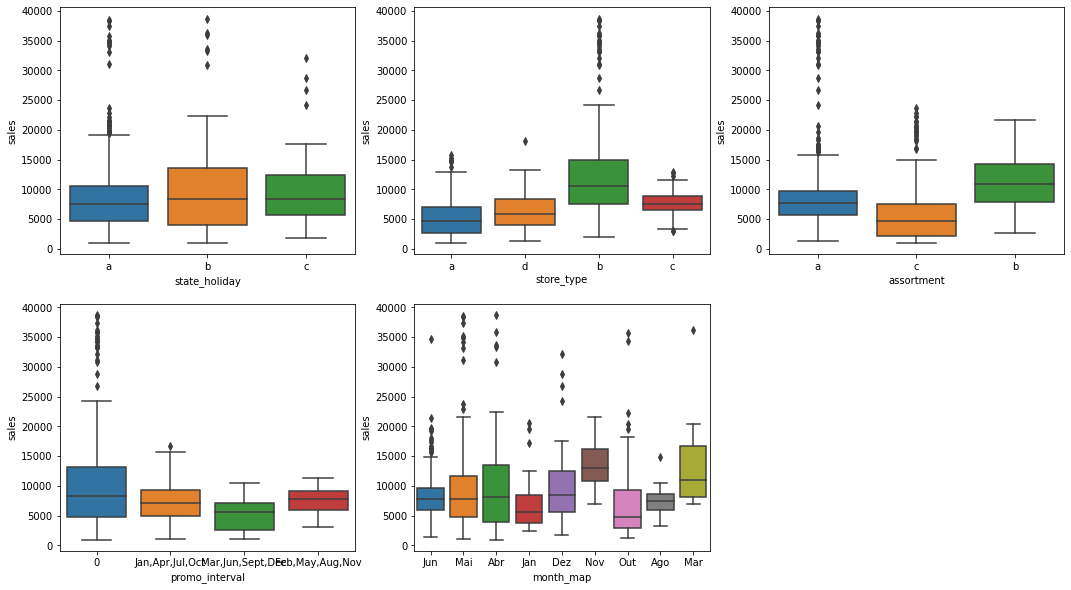

In [20]:
# df Aux
aux1 = df_raw[ (df_raw['state_holiday'] != '0') & (df_raw['sales'] > 0)]

# PLotting Box PLots
atts = cat_att.columns.to_list()

i=1 
plt.figure(figsize=(18,10))
for att in atts:
    plt.subplot(2,3, i )
    sns.boxplot(x=att, y='sales', data=aux1)
    i += 1

## Hypothesis Map

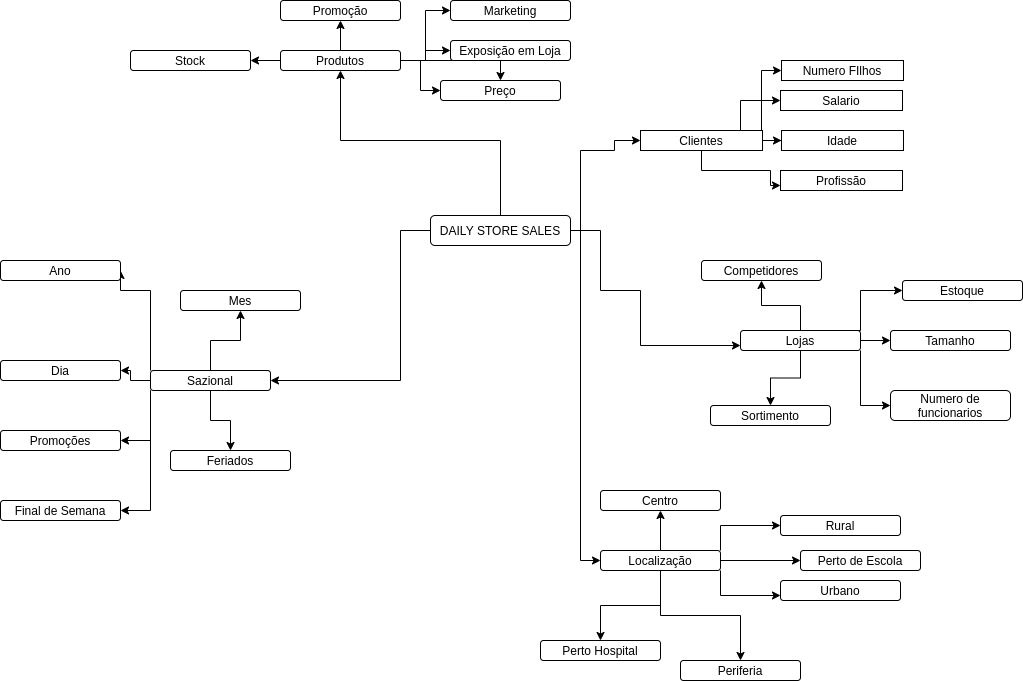

In [21]:
# Fenômeno, Agente, Atributos dos Agentes
path = '../reports/figures/rossman_hypoMap.png'
Image(path)

## Lista de Hipoteses

### Hipoóteses Loja


- Lojas com maior quadro de funcionários deveriam vender mais
- Lojas com maior estoque vendem mais.
- Lojas com maior porte  vendem mais.
- Lojas com maior sortimentos deveriam vender mais
- Lojas com competidores mais próximos deveriam vender mais
- Lojas com competidores a mais tempo deveriam vender mais

### Hipósteses Produto

- Lojas que investem mais em Marketing deveriam vender mais.
- Lojas que expoe mais o produtos nas vitrines deveriam vender mais.
- Lojas tem preços menores deveriam vender mais.
- Lojas com promoções mais agressivas(descontos maiores), deveriam vender mais
- Lojas com promoções ativas por mais tempo deveriam vender mais.
- Lojas com mais dias de promoção deveriam vender mais
- Lojas com mais promoções consecutivas deveriam vender mais.

### Hipóteses Tempo

 - Lojas abertas durante o feriado de Natal deveriam vender mais.
 - Lojas deveriam vender mais ao longo dos anos.
 - Lojas deveriam vender mais mais no segundo semestre do ano.
 - Lojas deveriam vender mais depois do dia 10 de cada mês.
 - Lojas deveriam vender menos aos finais de semana.
 - Lojas deveriam vender menos durante os feriados escolares.

### Lista Final

- Lojas com maior sortimentos deveriam vender mais
- Lojas com competidores mais próximos deveriam vender mais
- Lojas com competidores a mais tempo deveriam vender mais
- Lojas com promoções ativas por mais tempo deveriam vender mais.
- Lojas com mais dias de promoção deveriam vender mais
- Lojas com mais promoções consecutivas deveriam vender mais.
- Lojas abertas durante o feriado de Natal deveriam vender mais.
- Lojas deveriam vender mais ao longo dos anos.
- Lojas deveriam vender mais mais no segundo semestre do ano.
- Lojas deveriam vender mais depois do dia 10 de cada mês.
- Lojas deveriam vender menos aos finais de semana.
- Lojas deveriam vender menos durante os feriados escolares.

## Feature Engineering

In [22]:
df_feat = df_raw.copy()

In [23]:
# Variaveis que seram criadas

# year
df_feat['year'] = df_feat['date'].dt.year

# month
df_feat['month'] = df_feat['date'].dt.month

# day
df_feat['day'] = df_feat['date'].dt.day

# week of year
df_feat['week_of_year'] = df_feat['date'].dt.isocalendar().week

# year week
df_feat['year_week'] = df_feat['date'].dt.strftime('%Y-%W')

# competition since
df_feat['competition_since'] = df_feat.apply(lambda x : datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'] , day=1 ), axis=1)
df_feat['competition_time_month']=((df_feat['date'] - df_feat['competition_since'])/30).apply(lambda x: x.days).astype('int')

# promo since
df_feat['promo_since'] = df_feat['promo2_since_year'].astype(str) + '-' + df_feat['promo2_since_week'].astype(str) 
df_feat['promo_since'] = df_feat['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df_feat['promo_time_week'] = ((df_feat['date'] - df_feat['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df_feat['assortment']=df_feat['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df_feat['state_holiday']=df_feat['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [24]:
df_feat.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# Feature Selection - Negócios

In [25]:
df3 = df_feat.copy()

## Filtragem das Linhas

In [ ]:
# open != 0
# sales > 0

In [26]:
df3 = df3.loc[(df3['open'] != 0) & (df3['sales']>0), :]

## Seleção de Colunas

In [27]:
#'customers' - Modelo em separado para prever a quantidade de clientes daqui a 6 meses, sem isso não conseguimos usar
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# EDA - Análise Exploratoria

In [29]:
df4 = df3.copy()

## Analise Univariada

### Response Variable

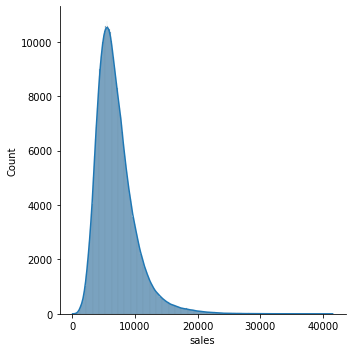

In [30]:
sns.displot(df4['sales'], kde=True)

### Numerical Variables

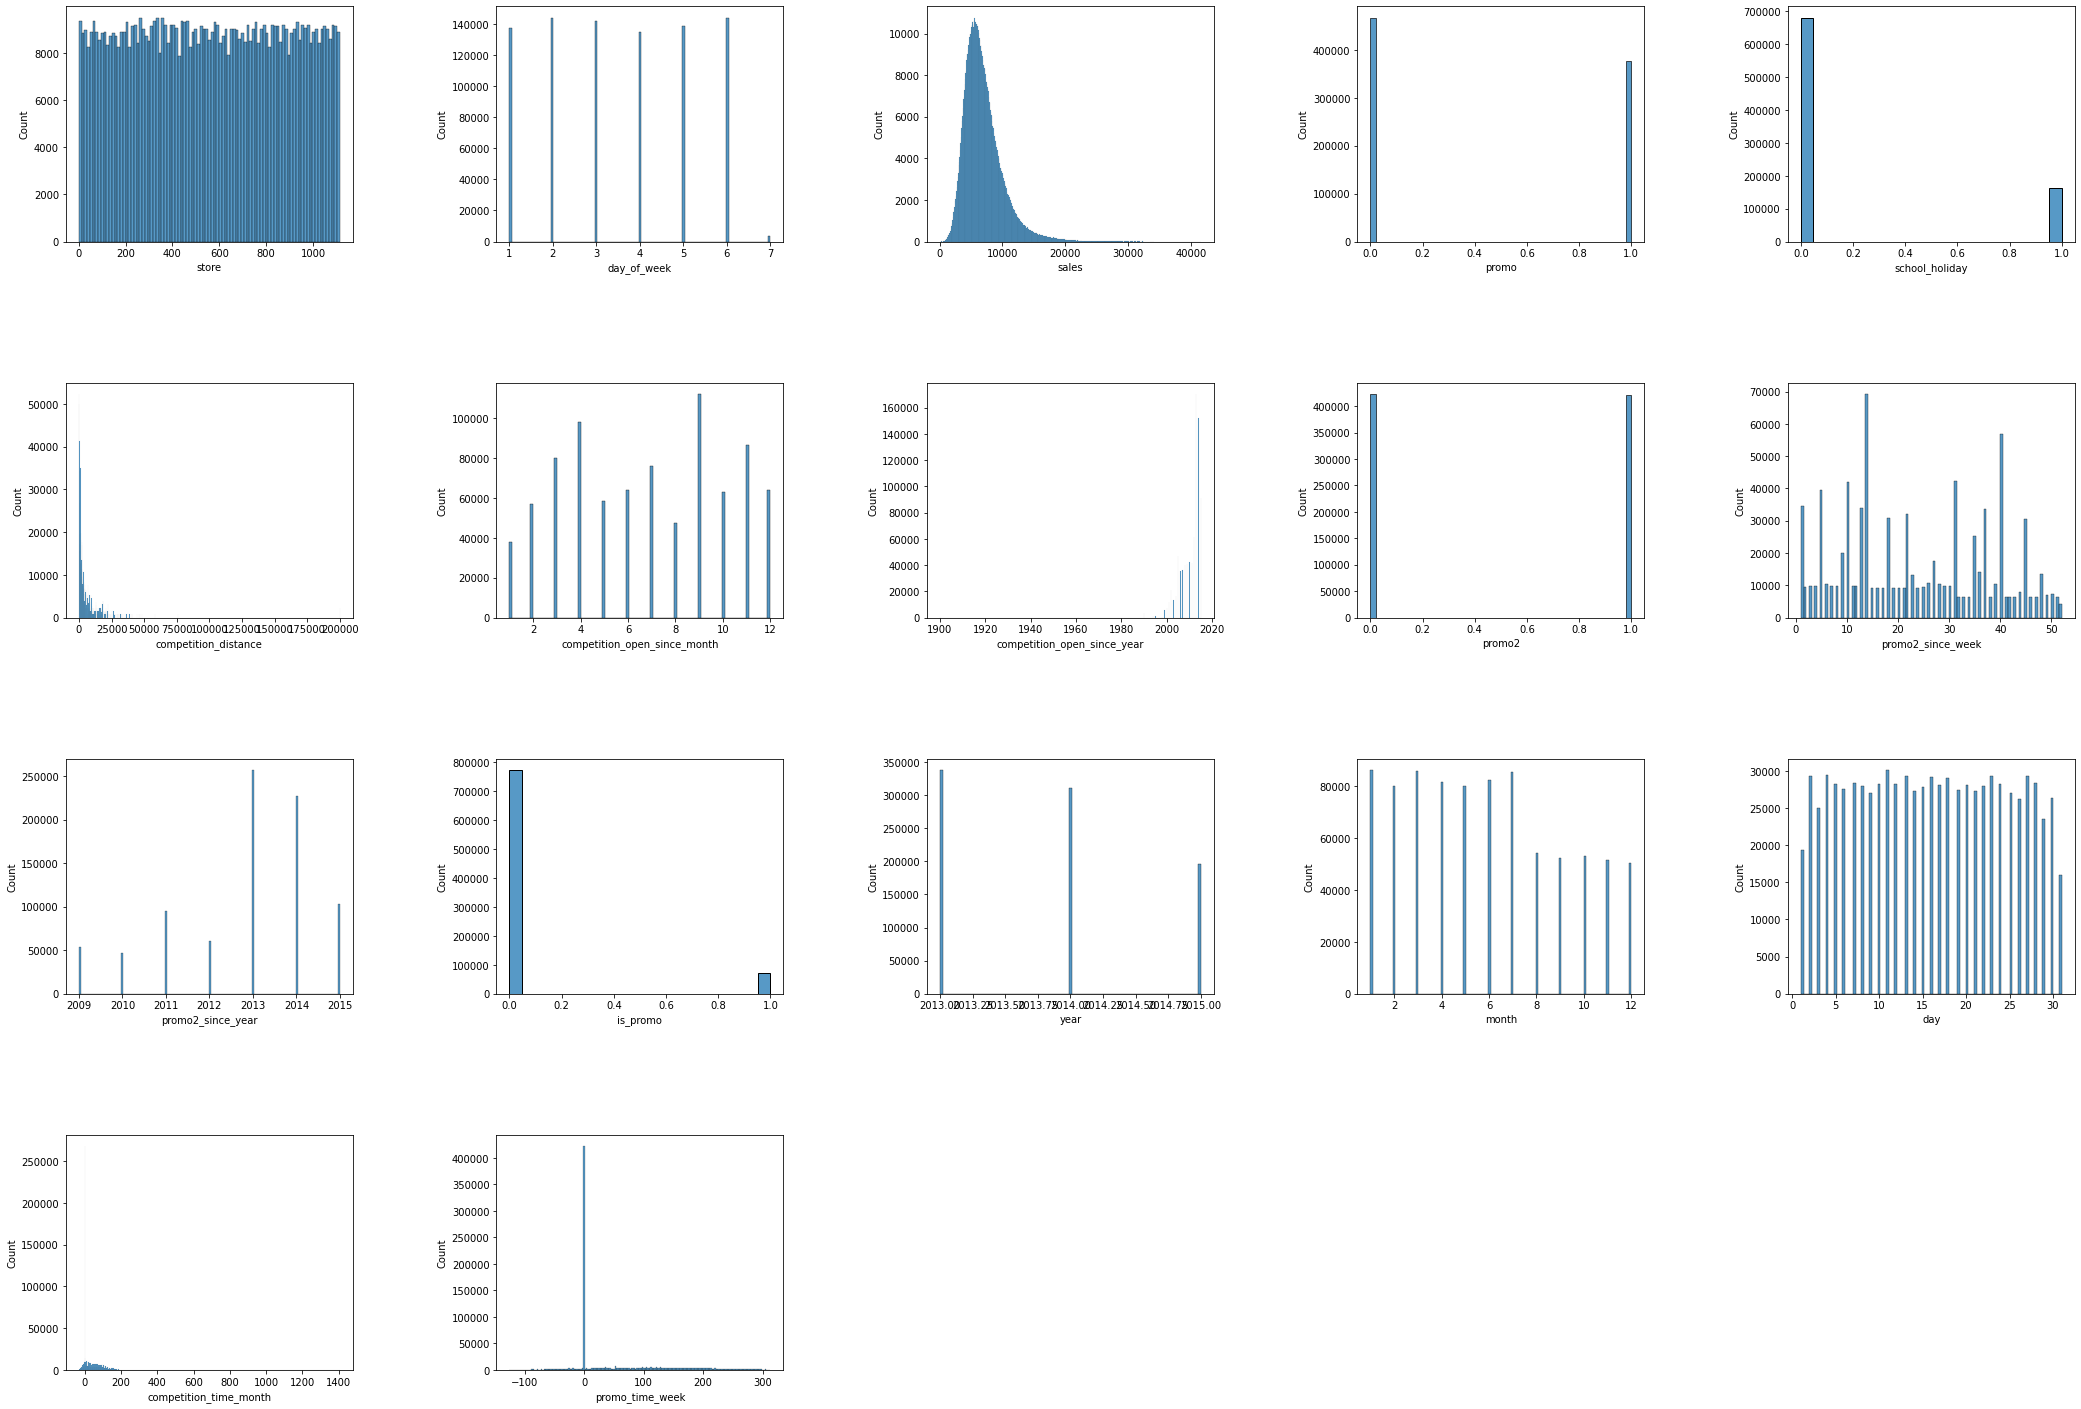

In [31]:
num_att = df4.select_dtypes(include=['int64', 'float64'])

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in num_att.columns.to_list():
    plt.subplot(5, 5, n)
    sns.histplot(x=column, data=num_att)
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

## Variáveis Categoricas

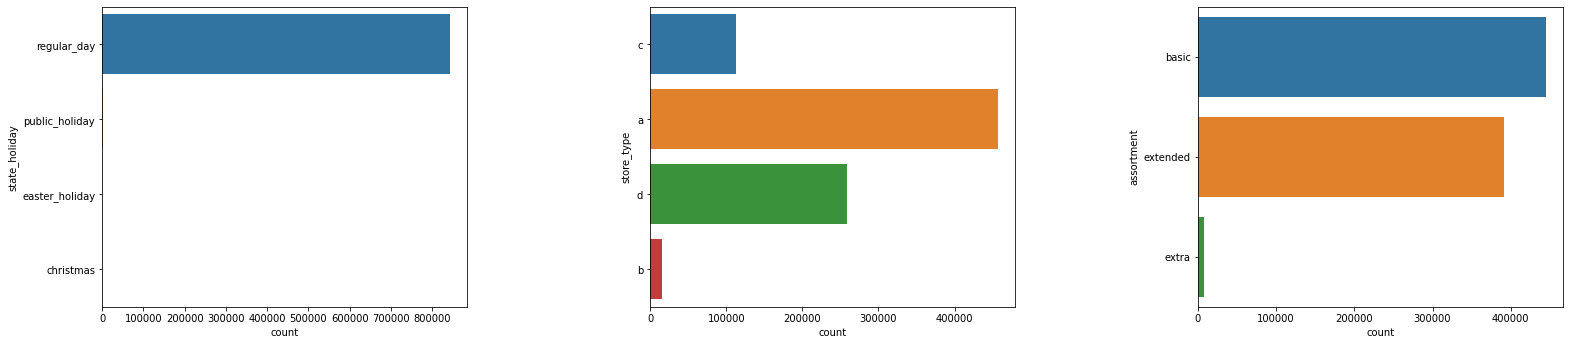

In [32]:
# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in df4[['state_holiday', 'store_type', 'assortment']].columns.to_list():
    plt.subplot(4, 4, n)
    sns.countplot(y=column, data=df4[['state_holiday', 'store_type', 'assortment']])
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

### state_holiday

In [33]:
temp = df4[['state_holiday', 'store_type', 'assortment']]
temp = temp[temp['state_holiday'] != 'regular_day']

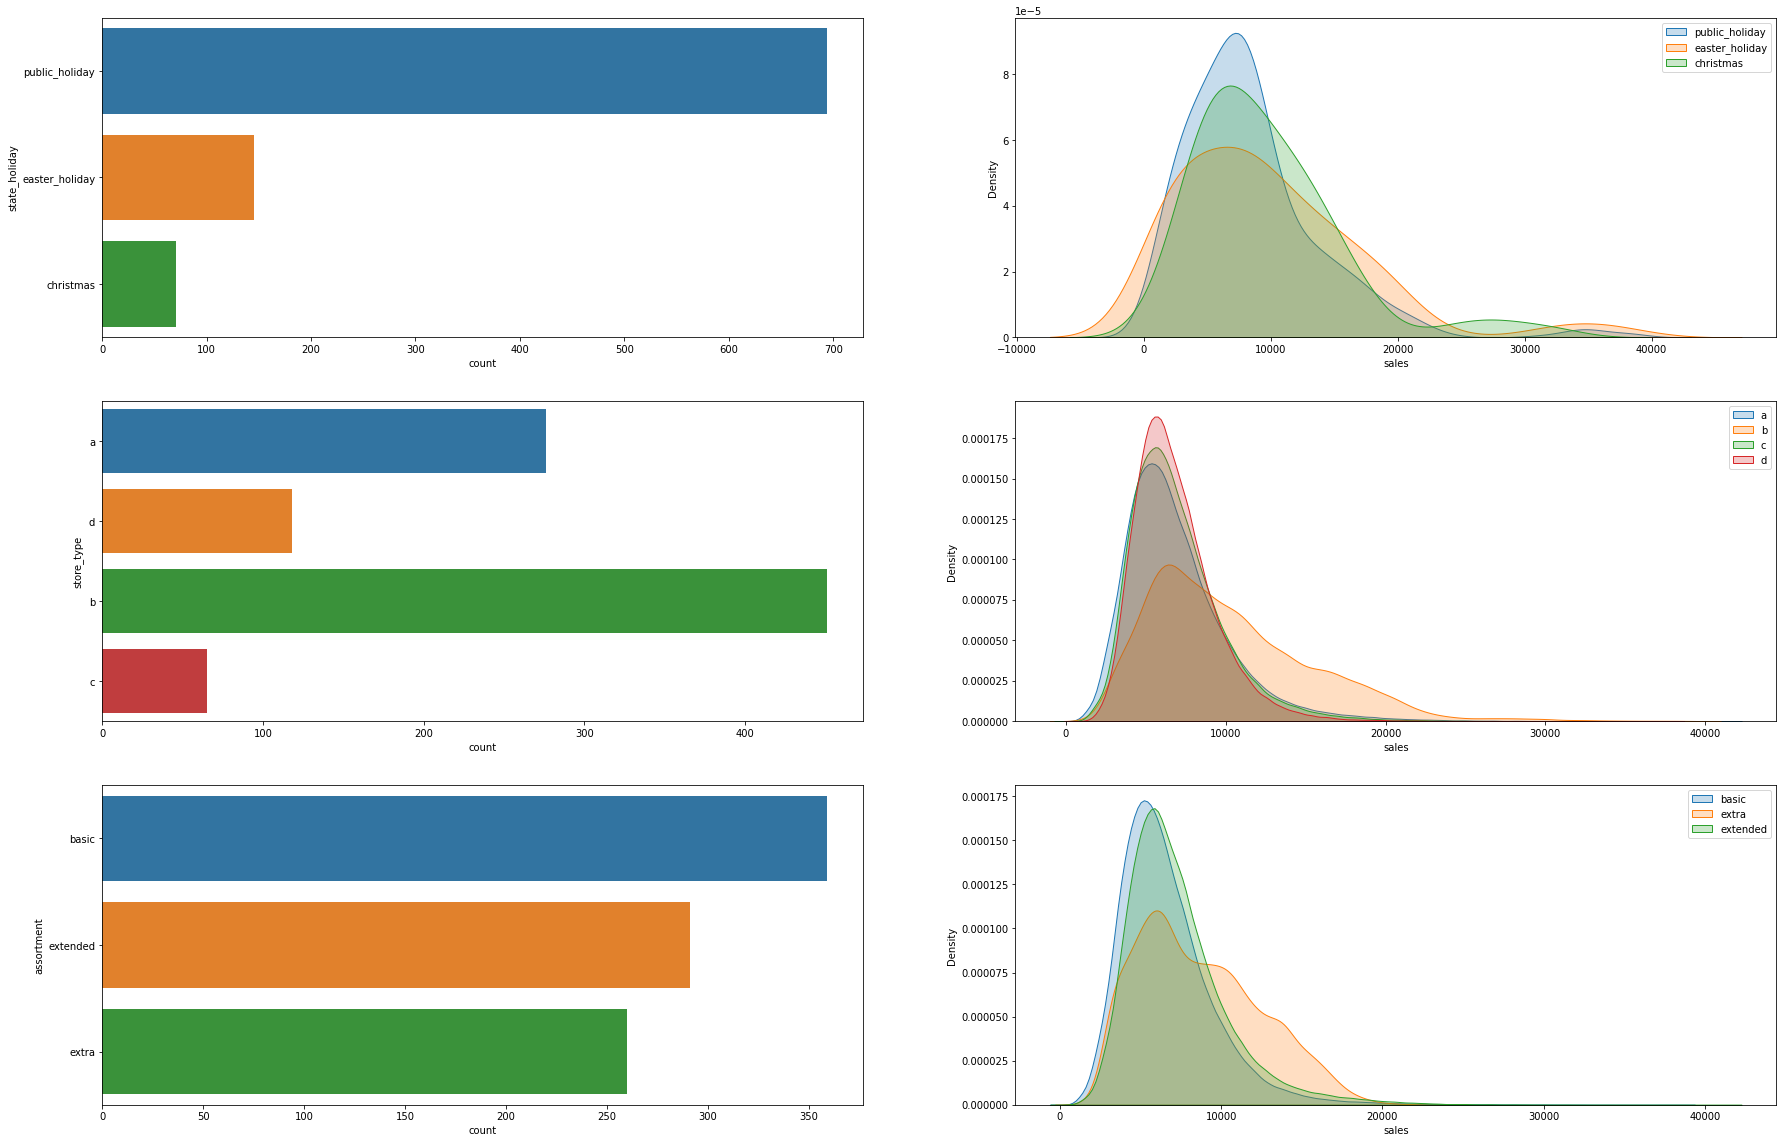

In [34]:
plt.figure(figsize=(30, 20))

# state_holiday
plt.subplot(3,2,1)

sns.countplot(y='state_holiday', data=temp)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(y='store_type', data=temp)


plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(y='assortment', data=temp)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label='extra', shade=True)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended', shade=True)
plt.legend()

## Análise Bivariada

### H1 - Lojas com maior sortimentos deveriam vender mais. - assortment, sales [False]

Lojas com assortment extra, possuem o menor volume de vendas.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

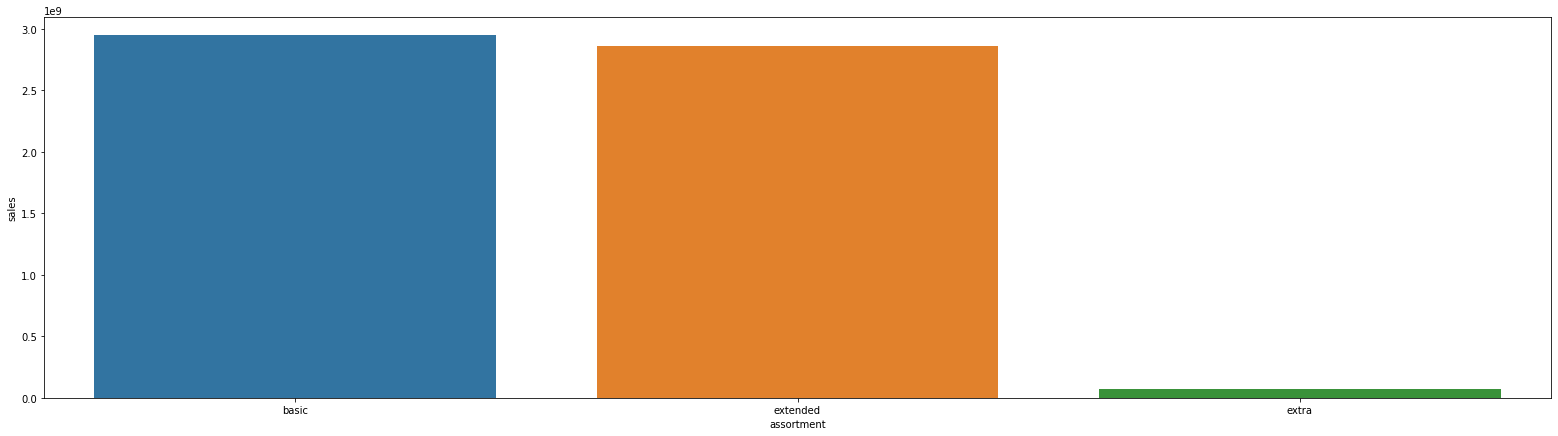

In [57]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(27,7))
sns.barplot(x='assortment', y='sales', data=aux1)

<AxesSubplot:xlabel='year_week'>

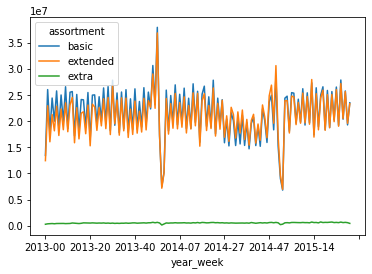

In [58]:
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week' ,columns='assortment' , values='sales').plot()

<AxesSubplot:xlabel='year_week'>

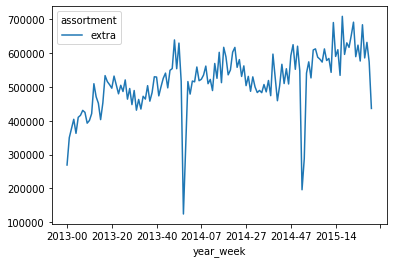

In [59]:
aux2 = aux2[aux2['assortment']=='extra']
aux2.pivot(index='year_week' ,columns='assortment' , values='sales').plot()

### H2 - Lojas com competidores mais próximos deveriam vender mais [False]
Lojas com competidores proximos vendem mais.



<AxesSubplot:xlabel='competition_distance_binned', ylabel='sales'>

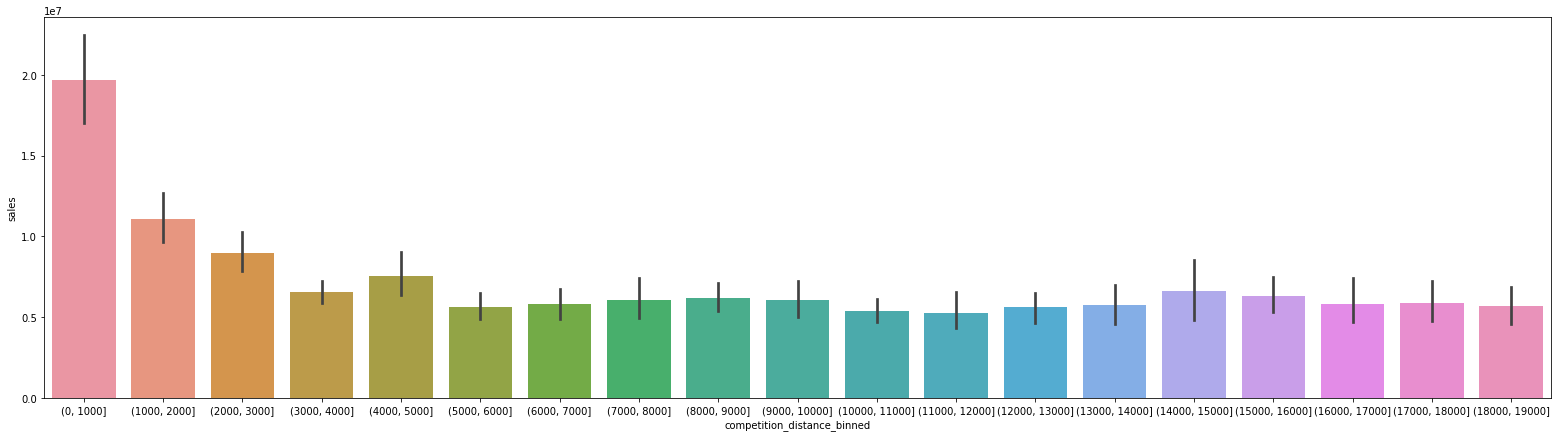

In [61]:
# bins
bins = list(np.arange(0,20000,1000))

# Aux1
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

# Aux2
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

# PLot
plt.figure(figsize=(27,7))
sns.barplot(x='competition_distance_binned', y='sales', data=aux1)


<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

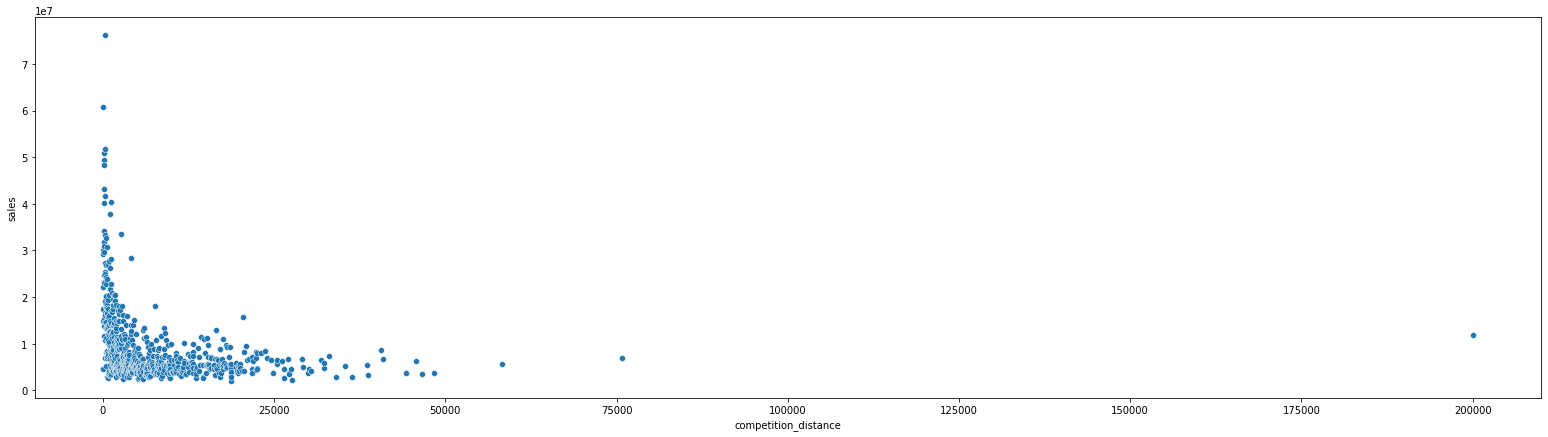

In [62]:
# scatterplot

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

# PLot
plt.figure(figsize=(27,7))
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

<AxesSubplot:>

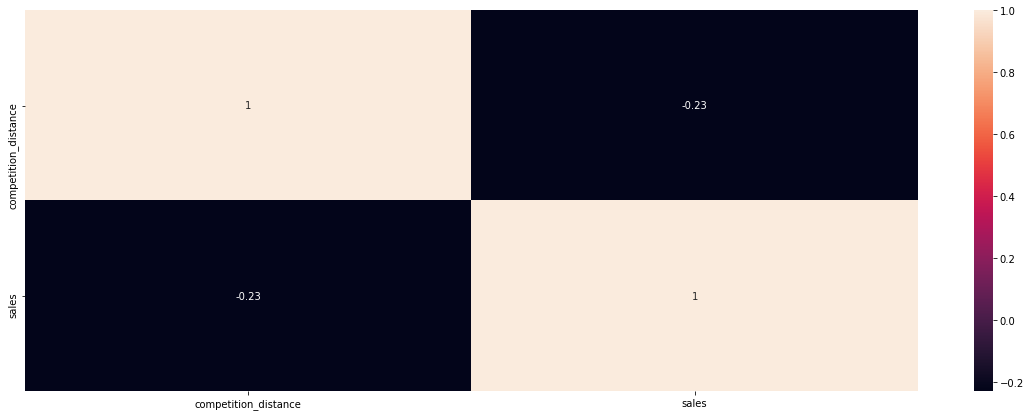

In [65]:
plt.figure(figsize=(20,7))
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H3 - Lojas com competidores a mais tempo deveriam vender mais


<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

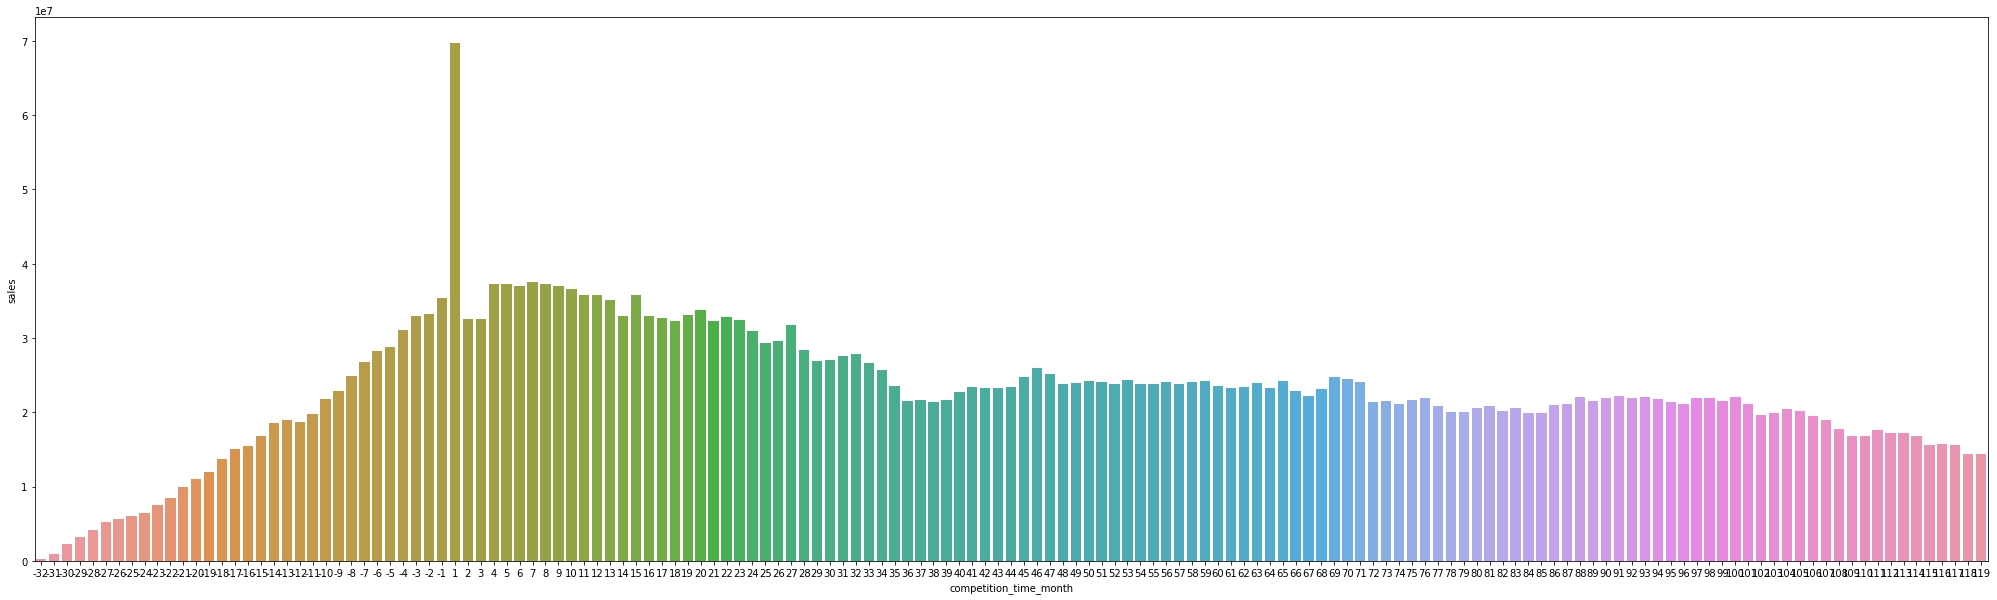

In [75]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux1 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

# Plot
plt.figure(figsize=(35,10))
sns.barplot(x='competition_time_month', y='sales', data=aux1)
#plt.xticks(rotation=90)

<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

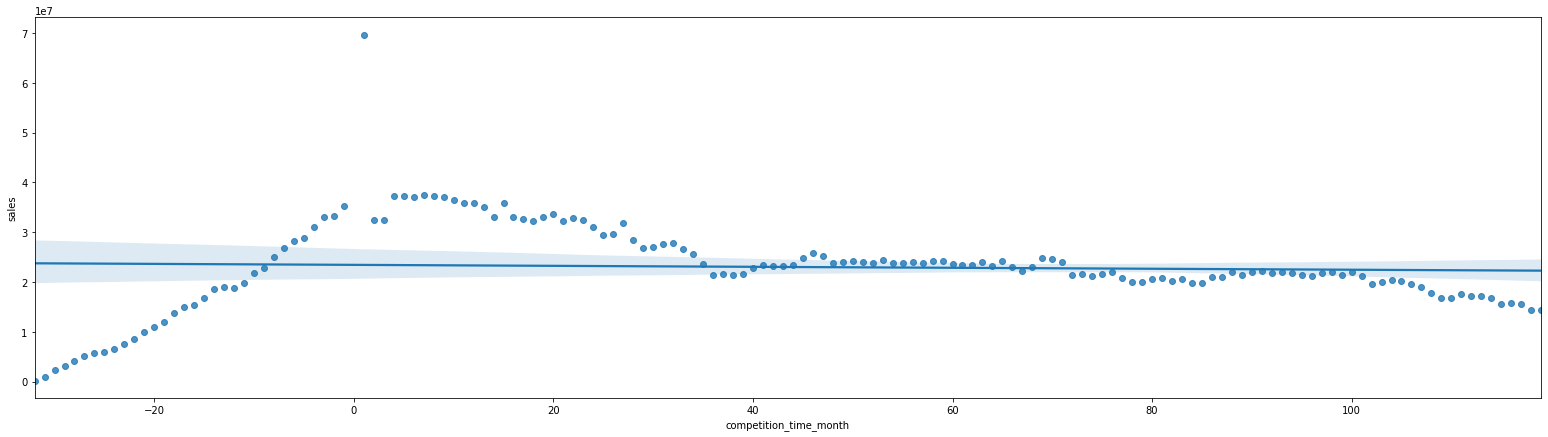

In [78]:
plt.figure(figsize=(27,7))
sns.regplot(x='competition_time_month', y='sales', data=aux1)

<AxesSubplot:>

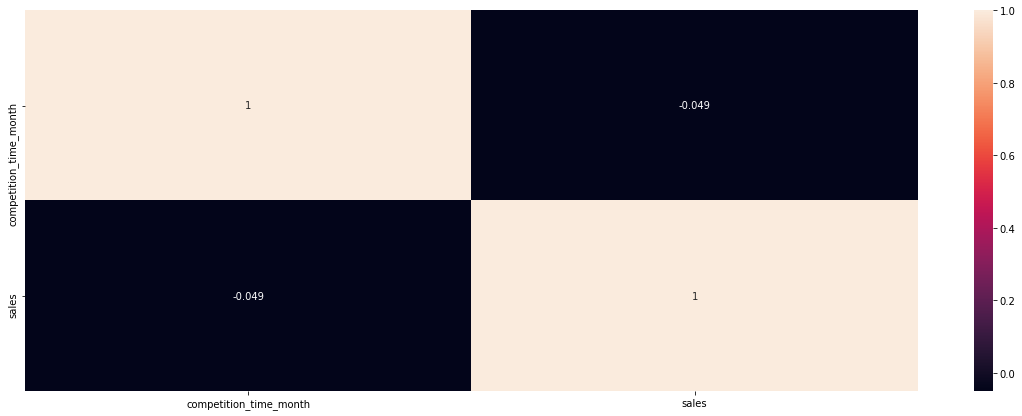

In [81]:
plt.figure(figsize=(20,7))
sns.heatmap(aux1.corr(method='pearson'), annot=True)

## Análise Multivariada